In [3]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:30:10_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0


In [4]:
!nvidia-smi

Tue Feb  4 15:33:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.16                 Driver Version: 572.16         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  |   00000000:09:00.0  On |                  Off |
|  0%   36C    P8             11W /  450W |     995MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
print('Device:', device)
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Count of using GPUs: 1


In [10]:
# 이미지를 출력하는 함수
def display_images(image_paths, title, max_images=4):
    """지정된 경로의 이미지를 최대 4개까지 출력합니다."""
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

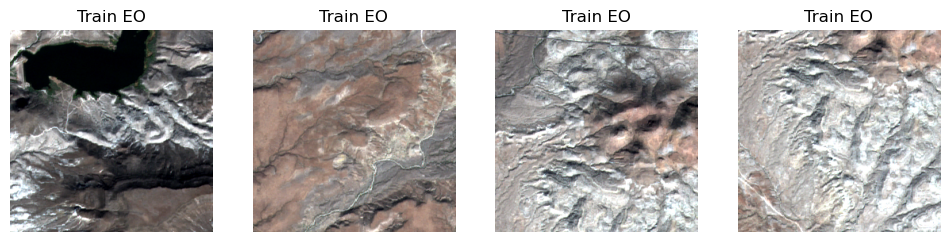

Train EO 총 이미지 수: 3213


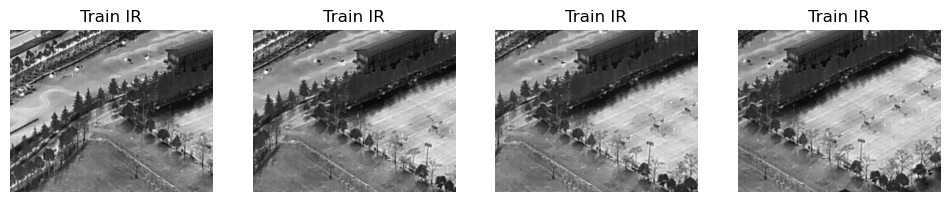

Train IR 총 이미지 수: 2008


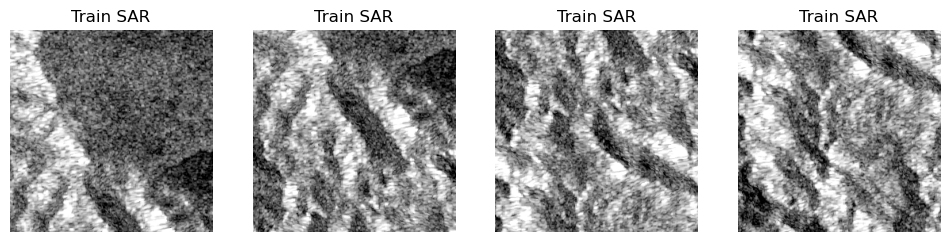

Train SAR 총 이미지 수: 3308


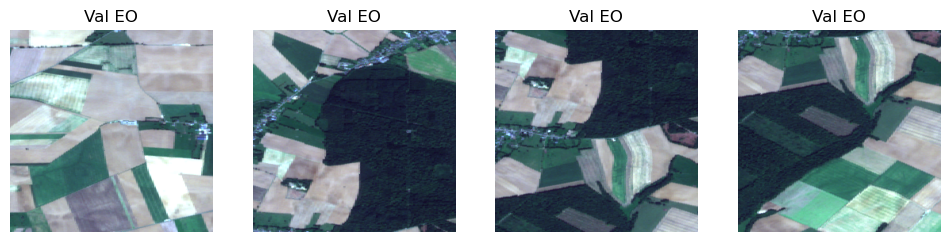

Val EO 총 이미지 수: 794


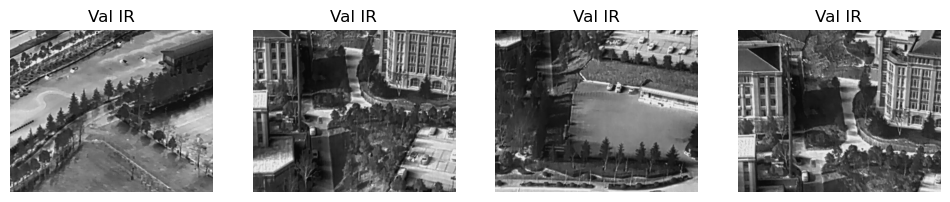

Val IR 총 이미지 수: 571


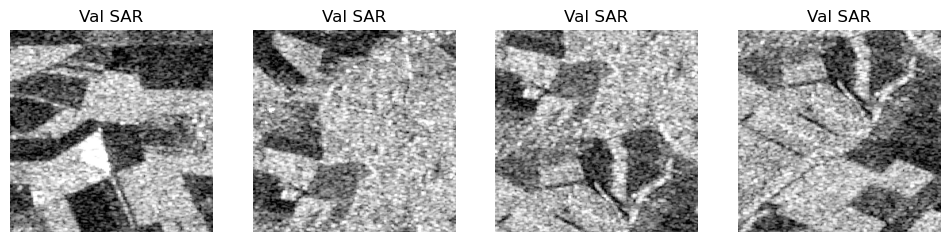

Val SAR 총 이미지 수: 320


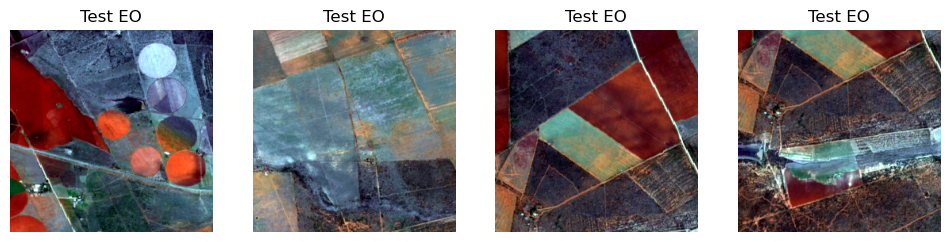

Test EO 총 이미지 수: 364


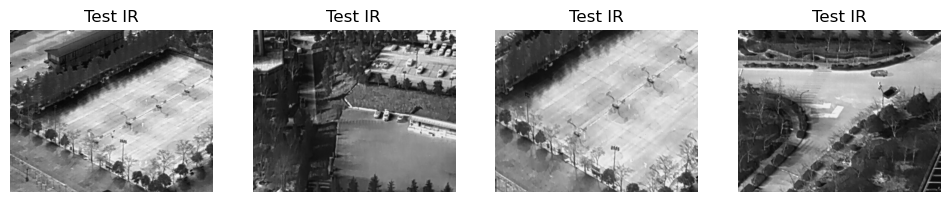

Test IR 총 이미지 수: 287


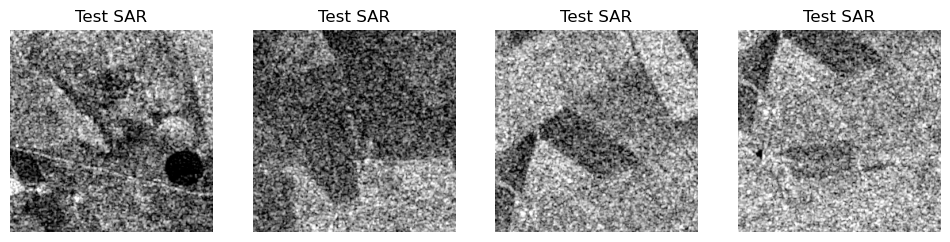

Test SAR 총 이미지 수: 321


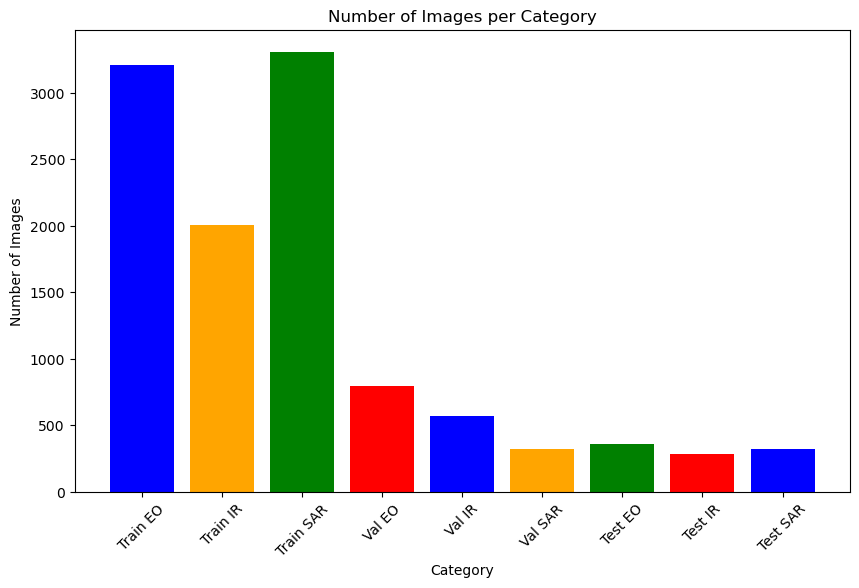

In [11]:
# 이미지와 바 그래프 출력
categories = ['Train EO', 'Train IR', 'Train SAR', 'Val EO', 'Val IR', 'Val SAR',
              'Test EO', 'Test IR', 'Test SAR']


for category in categories:
    image_paths = glob.glob(f'D:/CVProject/datasets/2-10/10/{category.lower().replace(" ", "/")}/*')
    display_images(image_paths, category)
    print(f"{category} 총 이미지 수: {len(image_paths)}")

# 바 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'D:/CVProject/datasets/2-10/10/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [12]:
from imgaug import augmenters as iaa
import imgaug as ia

# imgaug를 사용한 커스텀 데이터셋 정의
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Fliplr(0.5),  # 50% 확률로 좌우 반전
            iaa.Flipud(0.5),  # 50% 확률로 상하 반전
            iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0, 3.0))),  # 시그마는 0에서 3.0 사이의 값으로 블러를 추가
            iaa.Sometimes(0.2, iaa.Affine(rotate=(-25, 25))),  # -25도에서 +25도 사이로 회전
            iaa.Sometimes(0.2, iaa.AdditiveGaussianNoise(scale=(10, 60))),  # 평균 0, 표준편차가 10에서 60 사이의 가우시안 잡음 추가
            iaa.Sometimes(0.2, iaa.Multiply((0.8, 1.2)))  # 원본 이미지의 밝기를 80%에서 120% 사이로 조정
            ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

In [13]:
# 커스텀 데이터셋 클래스
class CustomDataset(ImageFolder):
    def __init__(self, root, imgaug=None, transform=None):
        super(CustomDataset, self).__init__(root, transform=transform)
        self.imgaug_transform = imgaug  # imgaug 매개변수를 직접 저장


    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        # imgaug 증강 적용
        if self.imgaug_transform is not None:
            img = self.imgaug_transform(img)
            # imgaug는 numpy 배열을 반환하므로, PIL Image로 다시 변환
            img = Image.fromarray(img)

        # ToTensor 및 Normalize 적용
        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [14]:
# PyTorch transforms에서 ToTensor 및 Normalize만 적용
from torchvision import transforms
pytorch_transforms = transforms.Compose([
    transforms.Resize((384, 384)),  # 이미지 크기 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
# 데이터셋 및 데이터 로더 초기화
train_dataset = CustomDataset('D:/CVProject/datasets/2-10/10/train', imgaug=ImgAugTransform(), transform=pytorch_transforms)
val_dataset = CustomDataset('D:/CVProject/datasets/2-10/10/val', imgaug=None, transform=pytorch_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

In [16]:
# DataLoader에서 샘플을 이미지를 load해 show하는 함수
def imshow(img, labels, class_to_idx, size=(20, 20), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # idx_to_class를 생성합니다: 인덱스를 클래스 이름으로 매핑
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean  # 역정규화
    img = np.clip(img, 0, 1)  # 값이 0과 1 사이에 오도록 클리핑
    plt.figure(figsize=size)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    # 이미지 위에 레이블 번호와 실제 클래스 이름 출력
    for i, label in enumerate(labels[:8]):  # 첫 8개의 이미지에 대해서만 실행
        class_name = idx_to_class[label.item()]
        x = (i % 4) * (img.shape[1] // 4) + 170  # 텍스트 x 위치
        y = (i // 4) * (img.shape[0] // 2) + 10  # 텍스트 y 위치
        plt.text(x, y, f'{label.item()}, {class_name}', color='red', fontsize=14)

    plt.show()

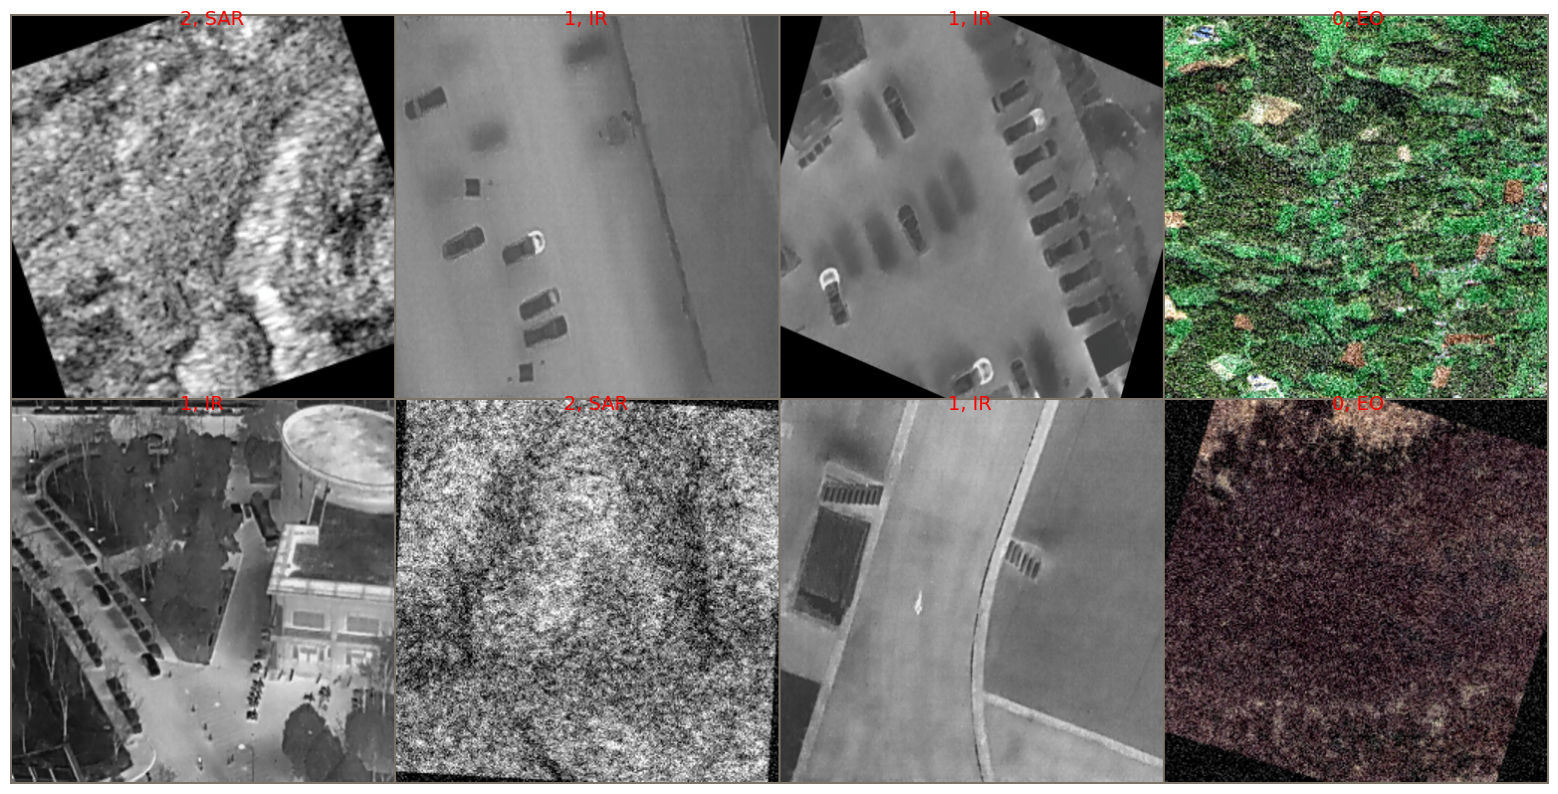

In [17]:
# DataLoader를 이용하여 배치 데이터 가져오기
dataiter = iter(train_loader)
images, label = next(dataiter)

# 이미지 그리드 생성 및 시각화, nrow를 조정하여 한 줄에 표시되는 이미지의 수 조정
class_to_idx = train_loader.dataset.class_to_idx  # DataLoader에서 class_to_idx 매핑 가져오기

imshow(make_grid(images[:8], nrow=4), label, class_to_idx, size=(20, 10))

In [18]:
# https://huggingface.co/models?pipeline_tag=image-classification&sort=trending
from transformers import ViTFeatureExtractor, ViTForImageClassification

# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch32-384')
ViTmodel = ViTForImageClassification.from_pretrained('google/vit-base-patch32-384')

In [19]:
# 모델의 모든 파라미터를 고정
for param in ViTmodel.parameters():
    param.requires_grad = False

# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
num_features = ViTmodel.classifier.in_features
ViTmodel.classifier = nn.Linear(num_features, 3)

for param in ViTmodel.classifier.parameters():
    param.requires_grad = True

ViTmodel = ViTmodel.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()

In [26]:
def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.00003, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # 학습/검증 손실과 검증 정확도 저장 리스트
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            outputs = outputs.logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        net.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                outputs = outputs.logits
                probabilities = F.softmax(outputs, 1)
                _, predicted = torch.max(probabilities, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [27]:
train_losses_ViTmodel, val_losses_ViTmodel, val_accuracies_ViTmodel = train_model('RAdam', ViTmodel, train_loader, val_loader, criterion)

Epoch 1/20: 100%|██████████████████████████████████████████████████████████████████████| 53/53 [00:17<00:00,  3.10it/s]


[RAdam] Epoch 1, Train Loss: 0.255141, Val Loss: 0.372120, Validation Accuracy: 91.22%


Epoch 2/20: 100%|██████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  5.93it/s]


[RAdam] Epoch 2, Train Loss: 0.162457, Val Loss: 0.292940, Validation Accuracy: 90.15%


Epoch 3/20: 100%|██████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.13it/s]


[RAdam] Epoch 3, Train Loss: 0.095551, Val Loss: 0.248602, Validation Accuracy: 90.33%


Epoch 4/20: 100%|██████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  5.95it/s]


[RAdam] Epoch 4, Train Loss: 0.060436, Val Loss: 0.216724, Validation Accuracy: 90.50%


Epoch 5/20: 100%|██████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  5.93it/s]


[RAdam] Epoch 5, Train Loss: 0.041086, Val Loss: 0.185147, Validation Accuracy: 91.51%


Epoch 6/20: 100%|██████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  5.94it/s]


[RAdam] Epoch 6, Train Loss: 0.032662, Val Loss: 0.159576, Validation Accuracy: 92.52%


Epoch 7/20: 100%|██████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.10it/s]


[RAdam] Epoch 7, Train Loss: 0.027270, Val Loss: 0.143673, Validation Accuracy: 93.47%


Epoch 8/20: 100%|██████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.14it/s]


[RAdam] Epoch 8, Train Loss: 0.023081, Val Loss: 0.135703, Validation Accuracy: 93.77%


Epoch 9/20: 100%|██████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  5.94it/s]


[RAdam] Epoch 9, Train Loss: 0.020930, Val Loss: 0.132428, Validation Accuracy: 94.12%


Epoch 10/20: 100%|█████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.19it/s]


[RAdam] Epoch 10, Train Loss: 0.017837, Val Loss: 0.132750, Validation Accuracy: 94.30%


Epoch 11/20: 100%|█████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  5.96it/s]


[RAdam] Epoch 11, Train Loss: 0.029980, Val Loss: 0.133877, Validation Accuracy: 94.54%


Epoch 12/20: 100%|█████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  5.95it/s]


[RAdam] Epoch 12, Train Loss: 0.013622, Val Loss: 0.135480, Validation Accuracy: 94.60%


Epoch 13/20: 100%|█████████████████████████████████████████████████████████████████████| 53/53 [00:09<00:00,  5.83it/s]


[RAdam] Epoch 13, Train Loss: 0.034841, Val Loss: 0.138340, Validation Accuracy: 94.78%


Epoch 14/20: 100%|█████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  5.95it/s]


[RAdam] Epoch 14, Train Loss: 0.033243, Val Loss: 0.141978, Validation Accuracy: 94.66%


Epoch 15/20: 100%|█████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  5.95it/s]


[RAdam] Epoch 15, Train Loss: 0.022997, Val Loss: 0.144093, Validation Accuracy: 94.78%


Epoch 16/20: 100%|█████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.07it/s]


[RAdam] Epoch 16, Train Loss: 0.022730, Val Loss: 0.145796, Validation Accuracy: 94.90%


Epoch 17/20: 100%|█████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  5.96it/s]


[RAdam] Epoch 17, Train Loss: 0.031954, Val Loss: 0.147659, Validation Accuracy: 95.01%


Epoch 18/20: 100%|█████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.14it/s]


[RAdam] Epoch 18, Train Loss: 0.025042, Val Loss: 0.149970, Validation Accuracy: 95.01%


Epoch 19/20: 100%|█████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.01it/s]


[RAdam] Epoch 19, Train Loss: 0.029998, Val Loss: 0.152943, Validation Accuracy: 95.19%


Epoch 20/20: 100%|█████████████████████████████████████████████████████████████████████| 53/53 [00:09<00:00,  5.59it/s]

[RAdam] Epoch 20, Train Loss: 0.025776, Val Loss: 0.156241, Validation Accuracy: 95.37%


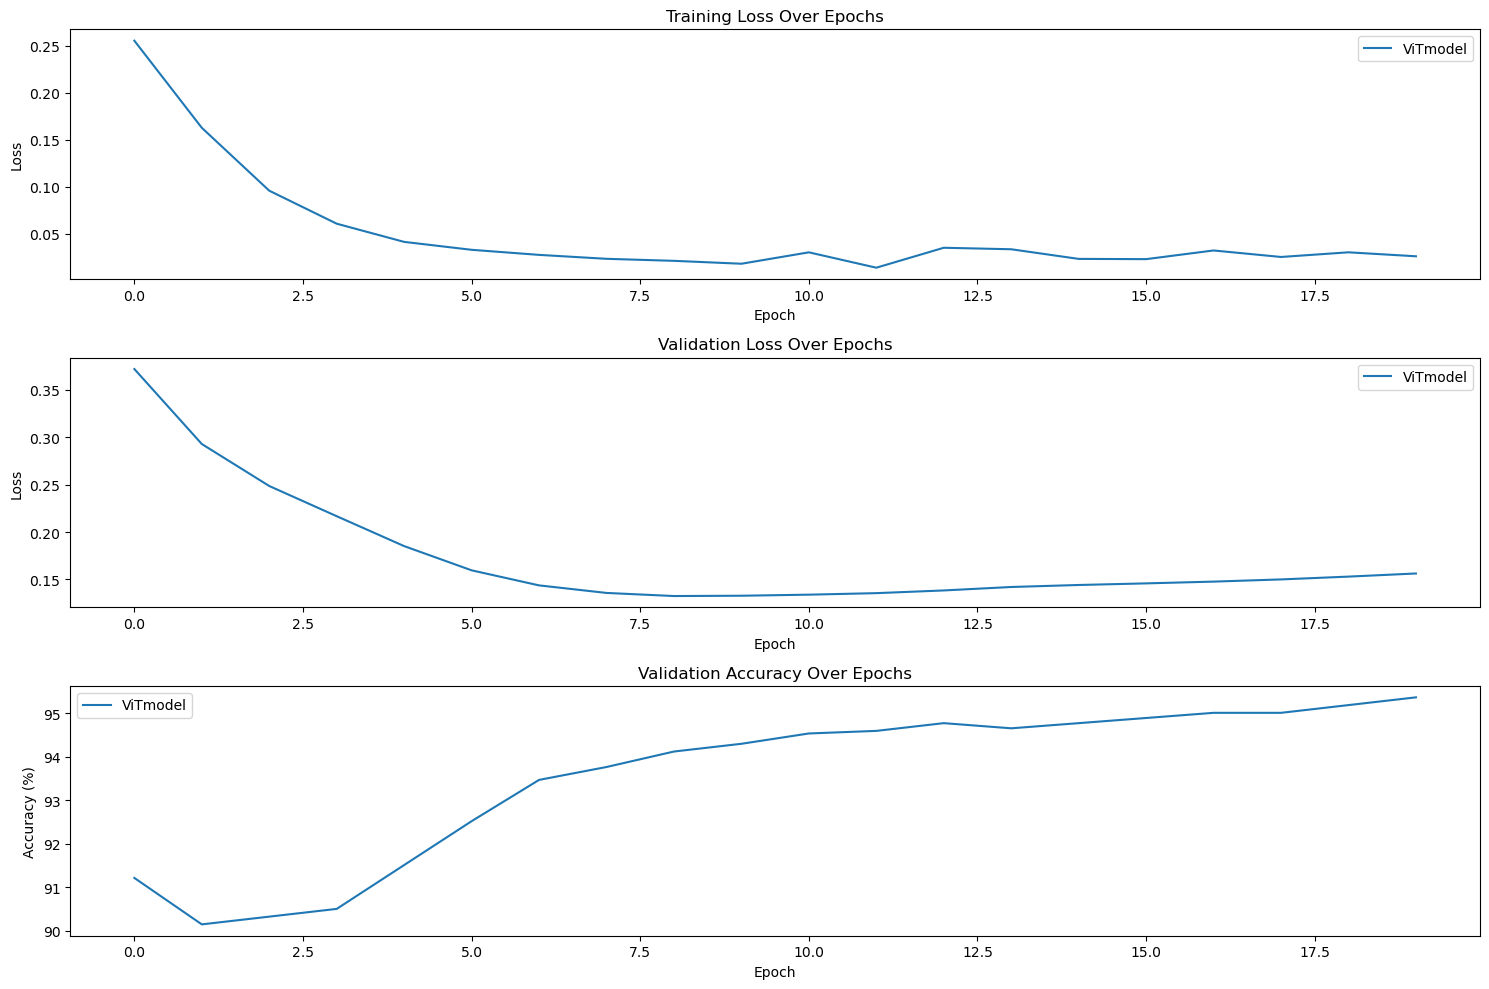

In [28]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_ViTmodel, label='ViTmodel')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_ViTmodel, label='ViTmodel')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_ViTmodel, label='ViTmodel')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# Image load 및 tensor로 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)  # 이미지를 모델에 맞게 변환하고 배치 차원 추가

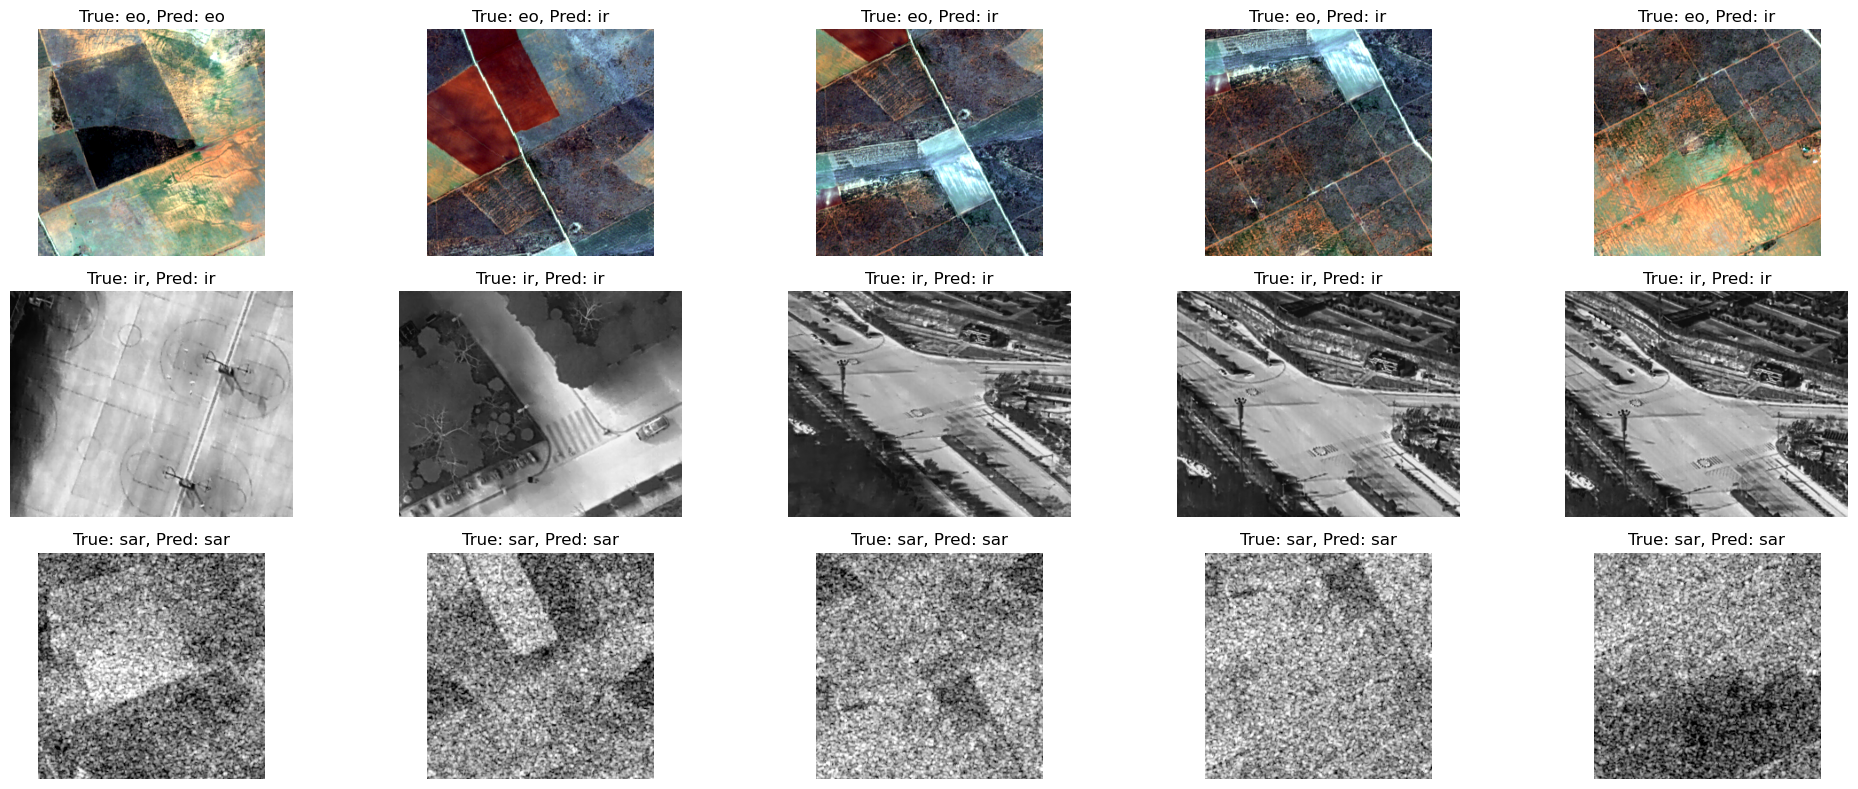

In [30]:
# 클래스별 폴더 경로
class_folders = {
    'eo': 'D:/CVProject/datasets/2-10/10/test/eo',
    'ir': 'D:/CVProject/datasets/2-10/10/test/ir',
    'sar': 'D:/CVProject/datasets/2-10/10/test/sar'
}


# idx_to_class 매핑 생성
idx_to_class = {idx: class_name for idx, class_name in enumerate(class_folders.keys())}

plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[30:35]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, pytorch_transforms)

        ViTmodel.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = ViTmodel(image)
            outputs = outputs.logits
            # 시그모이드 함수 적용하여 확률 얻기
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probabilities, 1)
            prediction = idx_to_class[predicted.item()]

        # 결과 시각화
        plt.subplot(3, 5, counter)
        plt.imshow(Image.open(image_path), cmap='gray')
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, class_folders, transform, target_class):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    # 레이블을 숫자로 변환하는 딕셔너리
    class_to_idx = {'eo': 0, 'ir': 1, 'sar': 2}


    for class_name, folder_path in class_folders.items():
        image_paths = glob.glob(os.path.join(folder_path, '*'))

        for image_path in image_paths:
            image = load_and_transform_image(image_path, transform)

            with torch.no_grad():
                outputs = model(image)
                outputs = outputs.logits
                probabilities = F.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)
                prediction = predicted.item()
                all_preds.append(prediction)
                all_labels.append(class_to_idx[class_name])


    # Calculate metrics for the target class
    target_preds = [1 if pred == class_to_idx[target_class] else 0 for pred in all_preds]
    target_labels = [1 if label == class_to_idx[target_class] else 0 for label in all_labels]

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(target_labels, target_preds, average='weighted')
    recall = recall_score(target_labels, target_preds, average='weighted')
    f1 = f1_score(target_labels, target_preds, average='weighted')

    return accuracy, precision, recall, f1

In [32]:
# Evaluate models for each class
for class_name in class_folders.keys():
    metrics = evaluate_model(ViTmodel, class_folders, pytorch_transforms, class_name)
    print(f"{class_name.capitalize()} Metrics: Accuracy: {metrics[0]:.4f}, Precision: {metrics[1]:.4f}, Recall: {metrics[2]:.4f}, F1: {metrics[3]:.4f}")

Eo Metrics: Accuracy: 0.8405, Precision: 0.8729, Recall: 0.8405, F1: 0.8280
Ir Metrics: Accuracy: 0.8405, Precision: 0.8965, Recall: 0.8405, F1: 0.8473
Sar Metrics: Accuracy: 0.8405, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
